# Exploratory Data Analysis - N-CMAPSS Dataset DS02

In [2]:
# imports
import os
import h5py
import time
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import DataFrame
import matplotlib.pyplot as plt
from matplotlib import gridspec
from pandas_profiling import ProfileReport
%matplotlib inline

In [3]:
# Read the file from DS02
filename = '../data/N-CMAPSS_DS02.h5'

# Setup save loc for graphs
graph_folder = '../graphs/'

## Read raw data from the h5 file. 

The dataset is seperated into two dev and test sets with 6 variable types in each:
* W - Scenario descriptors
* X_s - Physical sensor measurements
* X_t - Virtual sensor readings
* T - Health parameters
* Y - RUL (Remaining Useful Life)
* A - Auxiliary data

In [4]:
# Time tracking, Operation time (min):  0.003
t = time.process_time()  

# Load data
with h5py.File(filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                          
W = np.concatenate((W_dev, W_test), axis=0)  
X_s = np.concatenate((X_s_dev, X_s_test), axis=0)
X_v = np.concatenate((X_v_dev, X_v_test), axis=0)
T = np.concatenate((T_dev, T_test), axis=0)
Y = np.concatenate((Y_dev, Y_test), axis=0) 
A = np.concatenate((A_dev, A_test), axis=0) 
    
print('')
print("Operation time (min): " , (time.process_time()-t)/60)
print('')
print ("W shape: " + str(W.shape))
print ("X_s shape: " + str(X_s.shape))
print ("X_v shape: " + str(X_v.shape))
print ("T shape: " + str(T.shape))
print ("A shape: " + str(A.shape))


Operation time (min):  0.051348666666666674

W shape: (6517190, 4)
X_s shape: (6517190, 14)
X_v shape: (6517190, 14)
T shape: (6517190, 10)
A shape: (6517190, 4)


## Auxiliary Data (A)

There are 4 columns of auxiliary data included in the dataset:
* unit - unit number of the simulated engine (there are 9 distinct units)
* cycle - flight cycle number
* Fc - flight class - divided into three flight classes depending on whether the unit is operating short-length flights (i.e., flight class 1), medium-length flights (i.e., flight class 2), or long-length flights.

   | Flight Class   | Flight Length [h]
   | :-----------:  | :-----------:    
   | 1              |    1 to 3        
   | 2              |    3 to 5        
   | 3              |    5 to 7   



* hs - health state. 1 for healthy, 0 for faulty.


In [5]:
df_A = DataFrame(data=A, columns=A_var)
df_A.describe()

unit         cycle            Fc            hs
count  6.517190e+06  6.517190e+06  6.517190e+06  6.517190e+06
mean   1.166711e+01  3.692344e+01  2.885376e+00  2.424109e-01
std    6.039334e+00  2.187185e+01  3.867783e-01  4.285416e-01
min    2.000000e+00  1.000000e+00  1.000000e+00  0.000000e+00
25%    5.000000e+00  1.800000e+01  3.000000e+00  0.000000e+00
50%    1.100000e+01  3.600000e+01  3.000000e+00  0.000000e+00
75%    1.800000e+01  5.400000e+01  3.000000e+00  0.000000e+00
max    2.000000e+01  8.900000e+01  3.000000e+00  1.000000e+00

In [5]:
# Check the number of engine units
print('Engine units in df: ', np.unique(df_A['unit']))

Engine units in df:  [ 2.  5. 10. 11. 14. 15. 16. 18. 20.]


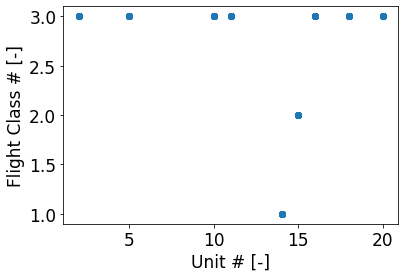

In [6]:
# Plot the flight classes per engine unit
labelsize = 17
plt.plot(df_A.unit, df_A.Fc, 'o')
plt.tick_params(axis='x', labelsize=labelsize )
plt.tick_params(axis='y', labelsize=labelsize )
plt.xlabel('Unit # [-]', fontsize=labelsize)
plt.ylabel('Flight Class # [-]', fontsize=labelsize )

plt.savefig(graph_folder + 'eda_flight_class_per_unit.jpeg', dpi=300, bbox_inches='tight')

Based on the flight class mapping, units 14 and 15 run short and medium haul flights respectively, while all other units operate long haul (>5 hour) flights.

The number of cycles to 'run-to-failure' differs by unit:

In [8]:
# Check total number of flight cycles per engine unit
for i in np.unique(df_A['unit']):
    print('Unit: ' + str(i) + ': ', len(np.unique(df_A.loc[df_A['unit'] == i, 'cycle'])))

occur = df_A.groupby('unit').size()
print(occur)

Unit: 2.0:  75
Unit: 5.0:  89
Unit: 10.0:  82
Unit: 11.0:  59
Unit: 14.0:  76
Unit: 15.0:  67
Unit: 16.0:  63
Unit: 18.0:  71
Unit: 20.0:  66
unit
2.0      853142
5.0     1033420
10.0     952711
11.0     663495
14.0     156778
15.0     433470
16.0     765295
18.0     890719
20.0     768160
dtype: int64


In [10]:
# Setup a common color palette for unit identification to help with observation,
def plot_df_color_per_unit(data, variables, labels, size=7, labelsize=17, option='Time', name=None):
    plt.clf()        
    input_dim = len(variables)
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs   = gridspec.GridSpec(rows, cols)
    leg  = []
    fig  = plt.figure(figsize=(size,max(size,rows*2)))
    color_dic_unit = {'Unit 1': 'C0', 'Unit 2': 'C1', 'Unit 3': 'C2', 'Unit 4': 'C3', 'Unit 5': 'C4', 'Unit 6': 'C5',
                      'Unit 7': 'C6', 'Unit 8': 'C7', 'Unit 9': 'C8', 'Unit 10': 'C9', 'Unit 11': 'C10',
                      'Unit 12': 'C11', 'Unit 13': 'C12', 'Unit 14': 'C13', 'Unit 15': 'C14', 'Unit 16': 'C15',
                      'Unit 17': 'C16', 'Unit 18': 'C17', 'Unit 19': 'C18', 'Unit 20': 'C19'} 
    
    unit_sel  = np.unique(data['unit'])
    for n in range(input_dim):
        ax = fig.add_subplot(gs[n])
        for j in unit_sel:
            data_unit = data.loc[data['unit'] == j]
            if option=='cycle':
                time_s = data.loc[data['unit'] == j, 'cycle']
                label_x = 'Time [cycle]'
            else:
                time_s = np.arange(len(data_unit))
                label_x = 'Time [s]'
            ax.plot(time_s, data_unit[variables[n]], '-o', color=color_dic_unit['Unit ' + str(int(j))],
                    alpha=0.7, markersize=5)
            ax.tick_params(axis='x', labelsize=labelsize)
            ax.tick_params(axis='y', labelsize=labelsize)
            leg.append('Unit '+str(int(j)))
        plt.ylabel(labels[n], fontsize=labelsize)    
        plt.xlabel(label_x, fontsize=labelsize)
        ax.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        if n==0:
            ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.legend(leg, loc='best', fontsize=labelsize-2) #lower left
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, dpi=300)   
    plt.show()
    plt.close()

# Setup single color plots
def plot_df_single_color(data, variables, labels, size=12, labelsize=17, name=None):
    plt.clf()        
    input_dim = len(variables)
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs   = gridspec.GridSpec(rows, cols)    
    fig  = plt.figure(figsize=(size,max(size,rows*2))) 
    
    for n in range(input_dim):
        ax = fig.add_subplot(gs[n])
        ax.plot(data[variables[n]], marker='.', markerfacecolor='none', alpha = 0.7)
        ax.tick_params(axis='x', labelsize=labelsize)
        ax.tick_params(axis='y', labelsize=labelsize)
        plt.ylabel(labels[n], fontsize=labelsize)
        plt.xlabel('Time [s]', fontsize=labelsize)
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, dpi=300)   
    plt.show()
    plt.close()

The health state is included for binary classification, not for the regression problem in our scope, but observing when health status changes might still be helpful:

<Figure size 432x288 with 0 Axes>

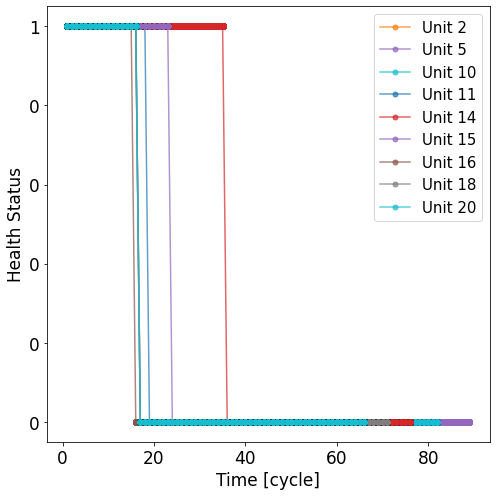

In [20]:
plot_df_color_per_unit(df_A, ['hs'], ['Health Status'], option='cycle', name=graph_folder + 'eda_hs_per_unit.jpeg')

## Scenario descriptors (w)

The four scenario description columns are:
* alt - altitude reading in ft
* Mach - Mach number of the flight
* TRA - throttle resolver angle
* T2 - total temperature at the fan inlet on the Rankine scale

In [15]:
df_W = DataFrame(data=W, columns=W_var)
df_W['unit'] = df_A['unit'].values
df_W.describe()

alt          Mach           TRA            T2          unit
count  6.517190e+06  6.517190e+06  6.517190e+06  6.517190e+06  6.517190e+06
mean   2.136379e+04  6.175633e-01  6.797217e+01  4.763986e+02  1.166711e+01
std    6.362768e+03  8.015034e-02  1.469880e+01  1.675431e+01  6.039334e+00
min    1.000100e+04  2.580480e-01  2.355452e+01  4.213779e+02  2.000000e+00
25%    1.588100e+04  5.587470e-01  5.835896e+01  4.626934e+02  5.000000e+00
50%    2.200300e+04  6.305040e-01  7.400338e+01  4.747415e+02  1.100000e+01
75%    2.700100e+04  6.815970e-01  7.962834e+01  4.908701e+02  1.800000e+01
max    3.503300e+04  7.492590e-01  8.762633e+01  5.111071e+02  2.000000e+01

<Figure size 432x288 with 0 Axes>

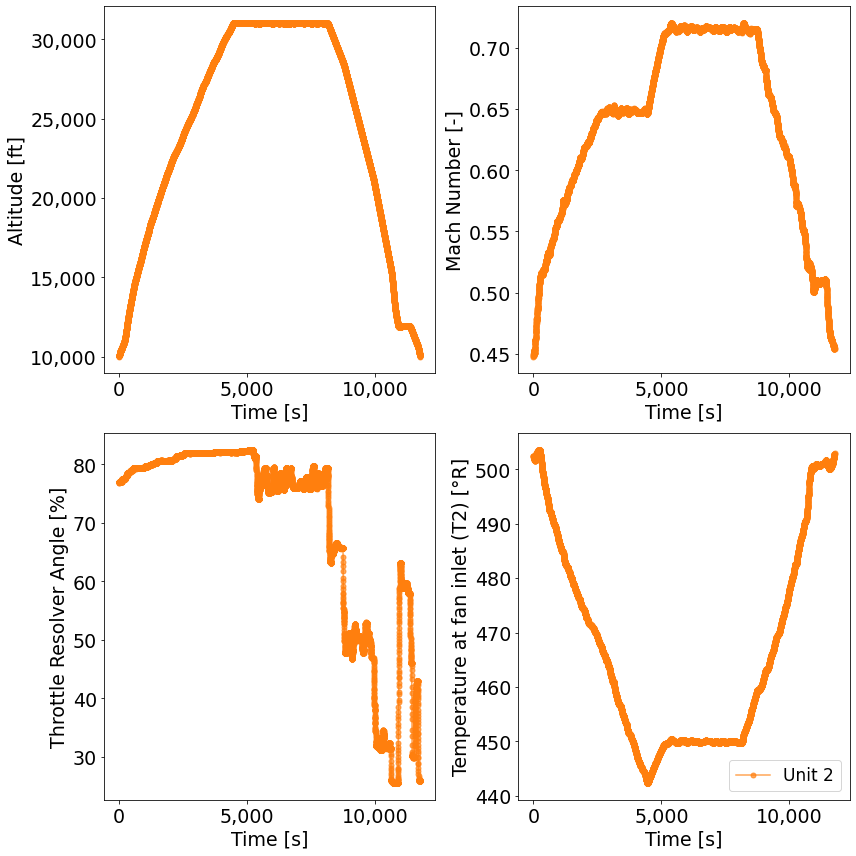

In [21]:
# Plot flight traces
df_W_u = df_W.loc[(df_A.unit == 2) & (df_A.cycle == 1)]
df_W_u.reset_index(inplace=True, drop=True)
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet (T2) [°R]']
plot_df_color_per_unit(df_W_u, W_var , labels, size=12, labelsize=19, name=graph_folder + 'eda_flight_traces.jpeg')

Flight envelope - doghouse plot would help identify whether there are any massive outliers/unreasonable values.

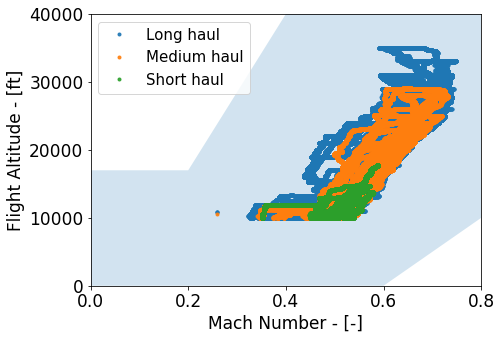

In [22]:
labelsize = 17
x = np.array([0.0, 0.2, 0.4, 0.6, 0.8])
u = np.array([1.7, 1.7, 4.0, 4.0, 4.0])*10000
l = np.array([0.0, 0.0, 0.0, 0.0, 1.0])*10000
plt.figure(figsize=(7,5)) 
plt.fill_between(x, l, u, alpha=0.2)
plt.plot(df_W.loc[df_A['Fc'] == 3, 'Mach'], df_W.loc[df_A['Fc'] == 3, 'alt'], '.', alpha=0.9)
plt.plot(df_W.loc[df_A['Fc'] == 2, 'Mach'], df_W.loc[df_A['Fc'] == 2, 'alt'], '.', alpha=0.9)
plt.plot(df_W.loc[df_A['Fc'] == 1, 'Mach'], df_W.loc[df_A['Fc'] == 1, 'alt'], '.', alpha=0.9)
plt.tick_params(axis='x', labelsize=labelsize )
plt.tick_params(axis='y', labelsize=labelsize )
plt.xlim((0.0, 0.8))
plt.ylim((0, 40000)) 
plt.xlabel('Mach Number - [-]', fontsize=labelsize)
plt.ylabel('Flight Altitude - [ft]', fontsize=labelsize)
plt.legend(['Long haul', 'Medium haul', 'Short haul'], loc='best', fontsize=labelsize-2)

plt.savefig(graph_folder + 'eda_flight_envelope.jpeg', dpi=300)

Generate a histogram of flight conditions as a KDE plot, with the same unit color schema.

<Figure size 432x288 with 0 Axes>

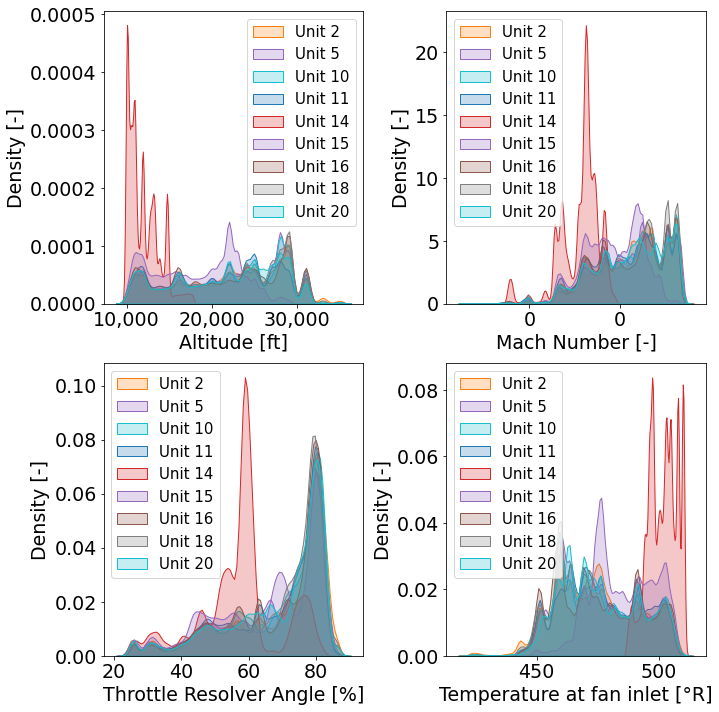

In [26]:
def plot_kde(leg, variables, labels, size, units, df_W, df_A, labelsize=17, name=None):
    plt.clf()
       
    input_dim = len(variables)
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs = gridspec.GridSpec(rows, cols)
    
    color_dic_unit = {'Unit 1': 'C0', 'Unit 2': 'C1', 'Unit 3': 'C2', 'Unit 4': 'C3', 'Unit 5': 'C4', 'Unit 6': 'C5',
                      'Unit 7': 'C6', 'Unit 8': 'C7', 'Unit 9': 'C8', 'Unit 10': 'C9', 'Unit 11': 'C10',
                      'Unit 12': 'C11', 'Unit 13': 'C12', 'Unit 14': 'C13', 'Unit 15': 'C14', 'Unit 16': 'C15',
                      'Unit 17': 'C16', 'Unit 18': 'C17', 'Unit 19': 'C18', 'Unit 20': 'C19'} 
    
    fig = plt.figure(figsize=(size,max(size,rows*2)))       

    for n in range(input_dim):
        ax = fig.add_subplot(gs[n])
        for k, elem in enumerate(units):
            sns.kdeplot(df_W.loc[df_A['unit'] == elem, variables[n]],
                        color=color_dic_unit[leg[k]], shade=True, gridsize=100)  
            ax.tick_params(axis='x', labelsize=labelsize)
            ax.tick_params(axis='y', labelsize=labelsize)
        
        ax.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))        
        plt.xlabel(labels[n], fontsize=labelsize)
        plt.ylabel('Density [-]', fontsize=labelsize)
        if n==0:
            plt.legend(leg, fontsize=labelsize-4, loc=0)
        else:
            plt.legend(leg, fontsize=labelsize-4, loc=2)
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, format='png', dpi=300)    
    plt.show()
    plt.close()

variables = ['alt', 'Mach', 'TRA', 'T2']
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet [°R]']
size = 10

units = list(np.unique(df_A['unit']))
leg = ['Unit ' + str(int(u)) for u in units]

plot_kde(leg, variables, labels, size, units, df_W, df_A, labelsize=19, name=graph_folder + 'eda_kde.jpeg')

## Model health parameters (T)

The imposed degradation conditions have been included as health parameters. There are 10 variables for degradation, but DS02 should only have 3 with triggers - HPT efficiency, LPT efficiency and flow. There are 5 components and 2 types of modifications for each.

   | Component      | Flow              | Efficiency
   | :-----------:  | :-----------:     | :-----------:    
   | Fan            |    fan_flow_mod   |     fan_eff_mod 
   | HPT            |    hpt_flow_mod   |     hpt_eff_mod
   | LPT            |    lpt_flow_mod   |     lpt_eff_mod
   | HPC            |    hpc_flow_mod   |     hpc_eff_mod
   | LPC            |    lpc_flow_mod   |     lpc_eff_mod


   The acronyms stand for:
   * HPC - High Pressure Compressor
   * LPC - Low Pressure Compressor
   * HPT - High Pressure Turbine
   * LPT - Low Pressure Turbine

In [27]:
df_T = DataFrame(data=T, columns=T_var) 
df_T['unit'] = df_A['unit'].values
df_T['cycle'] = df_A['cycle'].values
df_Ts = df_T.drop_duplicates()
df_Ts.describe()

fan_eff_mod  fan_flow_mod  LPC_eff_mod  LPC_flow_mod  HPC_eff_mod  \
count        648.0         648.0        648.0         648.0        648.0   
mean           0.0           0.0          0.0           0.0          0.0   
std            0.0           0.0          0.0           0.0          0.0   
min            0.0           0.0          0.0           0.0          0.0   
25%            0.0           0.0          0.0           0.0          0.0   
50%            0.0           0.0          0.0           0.0          0.0   
75%            0.0           0.0          0.0           0.0          0.0   
max            0.0           0.0          0.0           0.0          0.0   

       HPC_flow_mod  HPT_eff_mod  HPT_flow_mod  LPT_eff_mod  LPT_flow_mod  \
count         648.0   648.000000         648.0   648.000000    648.000000   
mean            0.0    -0.003271           0.0    -0.001792     -0.002024   
std             0.0     0.003452           0.0     0.003152      0.003209   
min             0.0    -0.018668           0.0    -0.023184     -0.021429   
25%             0.0    -0.004257           0.0    -0.001982     -0.002475   
50%             0.0    -0.001735           0.0    -0.000707     -0.000831   
75%             0.0    -0.001008           0.0     0.000000      0.000000   
max             0.0     0.000021           0.0     0.000075      0.000000   

             unit       cycle  
count  648.000000  648.000000  
mean    11.942901   37.060185  
std      5.689124   21.773268  
min      2.000000    1.000000  
25%      5.000000   18.750000  
50%     14.000000   36.500000  
75%     16.000000   54.250000  
max     20.000000   89.000000

In [29]:
# Plot the degradation params
import plotly.express as px
varsel = ['unit', 'HPT_eff_mod', 'LPT_eff_mod', 'LPT_flow_mod']
df_Tss = df_Ts.loc[:,varsel]
fig = px.parallel_coordinates(df_Tss, color="unit", labels={"unit": "Units",
                              "HPT_eff_mod": "HPT_eff_mod", "LPT_eff_mod": "LPT_eff_mod",
                              "LPT_flow_mod": "LPT_flow_mod", },
                              color_continuous_scale=px.colors.diverging.Tealrose,
                              color_continuous_midpoint=2)
fig.show()

<Figure size 432x288 with 0 Axes>

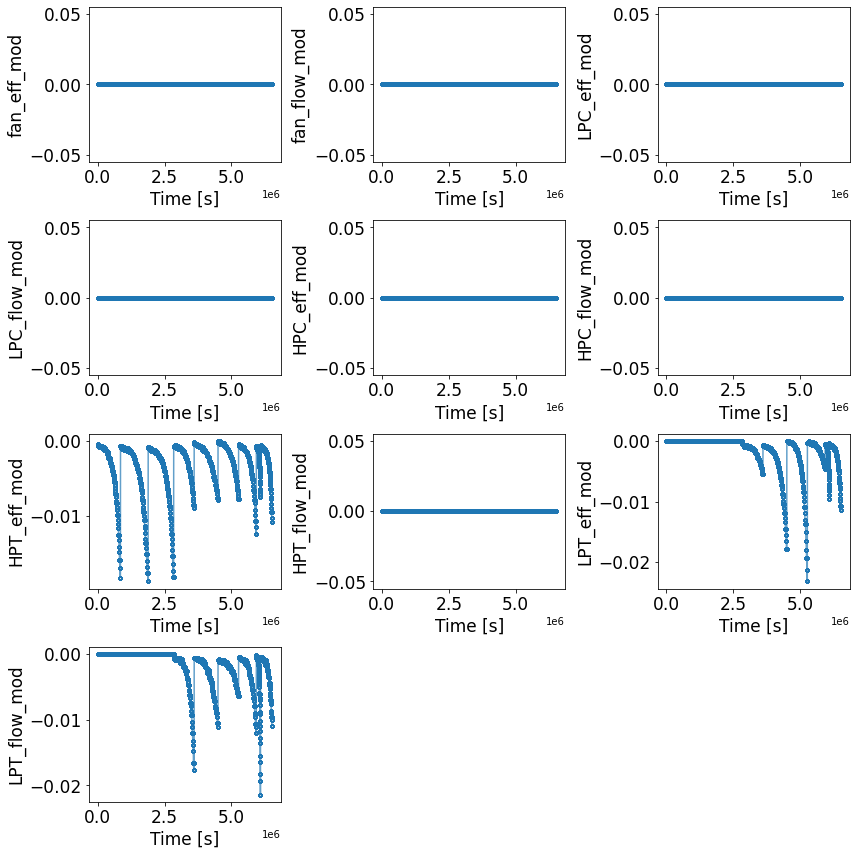

In [30]:
# Plot the degradation params seperately
labels = T_var
plot_df_single_color(df_T, T_var , labels, name=graph_folder + 'eda_degradation.jpeg')

As expected, only hpt_eff_mod, lpt_eff_mod and lpt_flow_mod have been introduced.

Plotting those three degradation params by unit (using the predefined color scheme):

<Figure size 432x288 with 0 Axes>

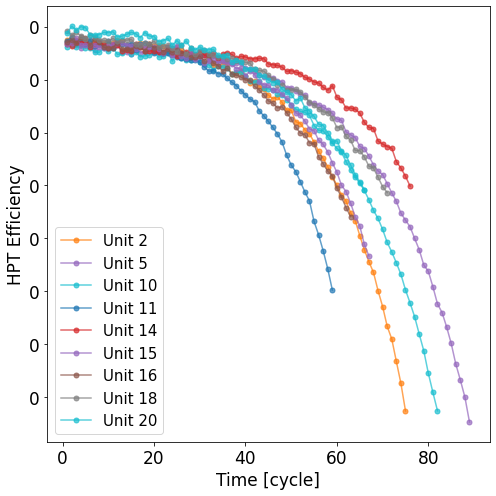

<Figure size 432x288 with 0 Axes>

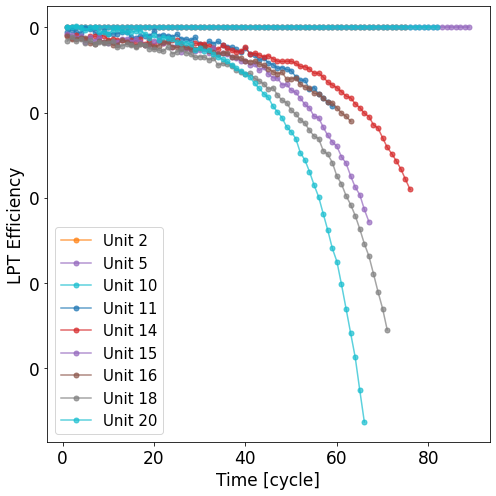

<Figure size 432x288 with 0 Axes>

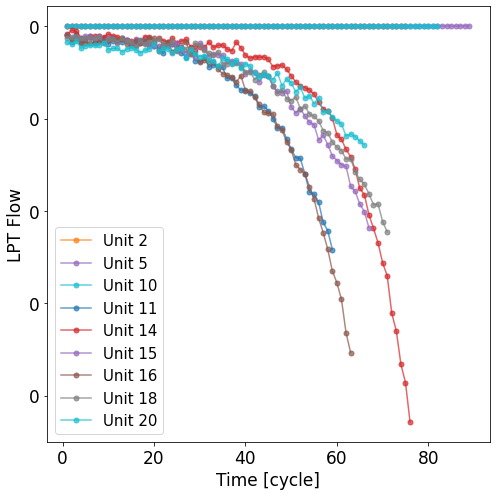

In [31]:
plot_df_color_per_unit(df_Ts, ['HPT_eff_mod'], [r'HPT Efficiency'], size=7,  option='cycle', name=graph_folder + 'eda_degradation_HPT_eff_mod.jpeg')
plot_df_color_per_unit(df_Ts, ['LPT_eff_mod'], [r'LPT Efficiency'], size=7,  option='cycle', name=graph_folder + 'eda_degradation_LPT_eff_mod.jpeg')
plot_df_color_per_unit(df_Ts, ['LPT_flow_mod'], [r'LPT Flow'], size=7,  option='cycle', name=graph_folder + 'eda_degradation_LPT_flow_mod.jpeg')

## Physical sensor readings (X_s)

There are 14 types of physical sensor readings in total:
* Wf - Fuel flow in pps
* Nf - Physical fan speed (rpm)
* Nc - Physical core speed (rpm)
* T24 - Total temperature at the LPC outlet
* T30 - Total temperature at the HPC outlet
* T48 - Total temperature at the HPT outlet
* T50 - Total temperature at the LPT outlet
* P15 - Total pressure in the bypass duct
* P2 - Total pressure in the fan inlet
* P21 - Total pressure at the fan outlet
* P24 - Total pressure at the LPC outlet
* Ps30 - Static pressure at the HPC outlet
* P40 - Total pressure at the burner outlet
* P50 - Total pressure at the LPT outlet

All temperature readings are in R (Rankine), and pressure has been measured in psia.

In [7]:
df_X_s = DataFrame(data=X_s, columns=X_s_var) 
df_X_s.describe()

T24           T30           T48           T50           P15  \
count  6.517190e+06  6.517190e+06  6.517190e+06  6.517190e+06  6.517190e+06   
mean   5.601856e+02  1.320972e+03  1.643787e+03  1.108384e+03  1.099942e+01   
std    1.812203e+01  5.610821e+01  9.966707e+01  5.216012e+01  2.176616e+00   
min    4.841972e+02  1.068823e+03  9.445005e+02  6.901948e+02  5.917596e+00   
25%    5.474414e+02  1.289850e+03  1.594647e+03  1.074531e+03  9.152022e+00   
50%    5.576452e+02  1.319964e+03  1.653845e+03  1.100314e+03  1.056151e+01   
75%    5.723608e+02  1.355735e+03  1.702724e+03  1.141552e+03  1.270294e+01   
max    6.167966e+02  1.487275e+03  1.912816e+03  1.284410e+03  1.691886e+01   

                 P2           P21           P24          Ps30           P40  \
count  6.517190e+06  6.517190e+06  6.517190e+06  6.517190e+06  6.517190e+06   
mean   8.390684e+00  1.116692e+01  1.380173e+01  2.109106e+02  2.145230e+02   
std    1.792750e+00  2.209762e+00  2.654274e+00  4.453682e+01  4.519087e+01   
min    4.373175e+00  6.007711e+00  6.914424e+00  8.033076e+01  8.209309e+01   
25%    6.801108e+00  9.291393e+00  1.162371e+01  1.790521e+02  1.821763e+02   
50%    8.034615e+00  1.072234e+01  1.329943e+01  2.006219e+02  2.040911e+02   
75%    9.873557e+00  1.289638e+01  1.572003e+01  2.383689e+02  2.424921e+02   
max    1.229306e+01  1.717651e+01  2.198497e+01  3.724845e+02  3.781559e+02   

                P50            Nf            Nc            Wf  
count  6.517190e+06  6.517190e+06  6.517190e+06  6.517190e+06  
mean   8.185567e+00  2.011350e+03  8.209696e+03  2.279800e+00  
std    1.930037e+00  1.404035e+02  1.861331e+02  5.769270e-01  
min    4.129153e+00  1.469742e+03  7.366108e+03  3.279842e-01  
25%    6.482449e+00  1.951916e+03  8.109963e+03  1.883696e+00  
50%    7.721369e+00  2.054166e+03  8.210638e+03  2.144380e+00  
75%    9.712406e+00  2.112240e+03  8.325700e+03  2.605430e+00  
max    1.321004e+01  2.263477e+03  8.745187e+03  4.539436e+00

Plot readings for unit 2 seperately:

<Figure size 432x288 with 0 Axes>

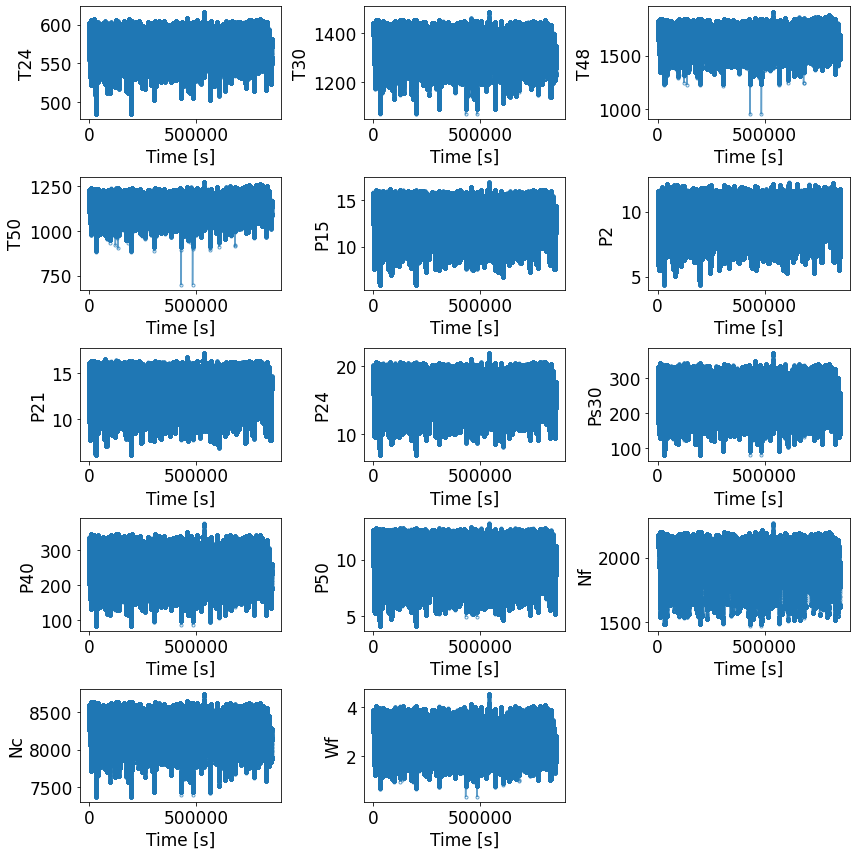

In [11]:
df_X_s_u = df_X_s.loc[df_A.unit == 2]
df_X_s_u.reset_index(inplace=True, drop=True)
labels = X_s_var
plot_df_single_color(df_X_s_u, X_s_var, labels, name=graph_folder + 'eda_physical_sensor_unit_2.jpeg')

Plot sensor readings for the same unit (2) by flight cycle over time for flight cycle 1:

<Figure size 432x288 with 0 Axes>

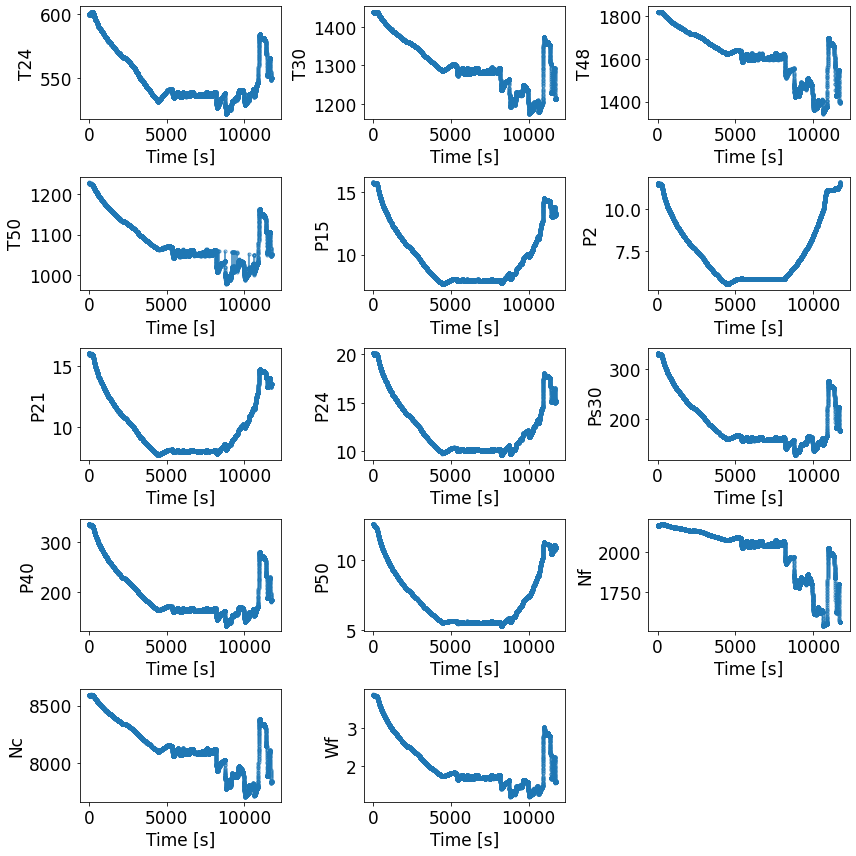

In [34]:
df_X_s_u_c = df_X_s.loc[(df_A.unit == 2) & (df_A.cycle == 1)]
df_X_s_u_c.reset_index(inplace=True, drop=True)
plot_df_single_color(df_X_s_u_c, X_s_var, X_s_var, name=graph_folder + 'eda_physical_sensor_unit_2_cycle_1.jpeg')

## Virtual Sensors (X_v)

There are 14 types of virtual sensor readings:
* T40 - Total temperature at burner outlet
* P30 - Total pressure at HPC outlet
* P45 - Total pressure at HPT outlet
* W21 - Fan flow
* W22 - Flow out of LPC
* W25 - Flow into HPC
* W31 - HPT coolant bleed
* W32 - LPT coolant bleed
* W48 - Flow out of HPT
* W50 - Flow out of LPT
* SmFan - Fan stall margin
* SmLPC - LPC stall margin
* SmHPC - HPC stall margin
* phi - Ratio of fuel flow to static pressure at the HPC outlet

Flows have been measured in lbm/s, pressure in psia and temperature in Rankine.


In [35]:
df_X_v = DataFrame(data=X_v, columns=X_v_var) 
df_X_v.describe()

T40           P30           P45           W21           W22  \
count  6.517190e+06  6.517190e+06  6.517190e+06  6.517190e+06  6.517190e+06   
mean   2.544126e+03  2.246314e+02  3.989898e+01  1.741042e+03  1.539627e+02   
std    1.438983e+02  4.732028e+01  8.510726e+00  2.980279e+02  2.816819e+01   
min    1.456733e+03  8.596136e+01  1.492471e+01  9.777402e+02  6.999450e+01   
25%    2.474978e+03  1.907605e+02  3.383487e+01  1.493542e+03  1.331599e+02   
50%    2.560213e+03  2.137079e+02  3.793247e+01  1.692549e+03  1.478083e+02   
75%    2.629081e+03  2.539185e+02  4.509897e+01  1.961384e+03  1.725026e+02   
max    2.928343e+03  3.959747e+02  7.110787e+01  2.616388e+03  2.505788e+02   

                W25           W31           W32           W48           W50  \
count  6.517190e+06  6.517190e+06  6.517190e+06  6.517190e+06  6.517190e+06   
mean   1.539627e+02  1.769559e+01  1.061735e+01  1.438445e+02  1.523126e+02   
std    2.816804e+01  3.327350e+00  1.996410e+00  2.717437e+01  2.872355e+01   
min    7.003366e+01  7.781476e+00  4.668886e+00  6.289777e+01  6.674977e+01   
25%    1.331597e+02  1.523824e+01  9.142945e+00  1.238315e+02  1.311555e+02   
50%    1.478084e+02  1.696862e+01  1.018117e+01  1.378728e+02  1.460030e+02   
75%    1.725031e+02  1.988567e+01  1.193140e+01  1.616681e+02  1.711563e+02   
max    2.505746e+02  2.910788e+01  1.746473e+01  2.373755e+02  2.511568e+02   

              SmFan         SmLPC         SmHPC           phi  
count  6.517190e+06  6.517190e+06  6.517190e+06  6.517190e+06  
mean   1.928305e+01  8.143954e+00  2.791921e+01  3.861810e+01  
std    1.502687e+00  9.398687e-01  2.050580e+00  2.268915e+00  
min    1.446133e+01  2.129204e+00  2.384662e+01  1.434352e+01  
25%    1.816422e+01  7.669756e+00  2.639292e+01  3.761764e+01  
50%    1.903723e+01  8.286749e+00  2.753004e+01  3.897536e+01  
75%    1.995961e+01  8.841465e+00  2.880096e+01  4.015212e+01  
max    2.730431e+01  1.105057e+01  5.479002e+01  4.388362e+01

<Figure size 432x288 with 0 Axes>

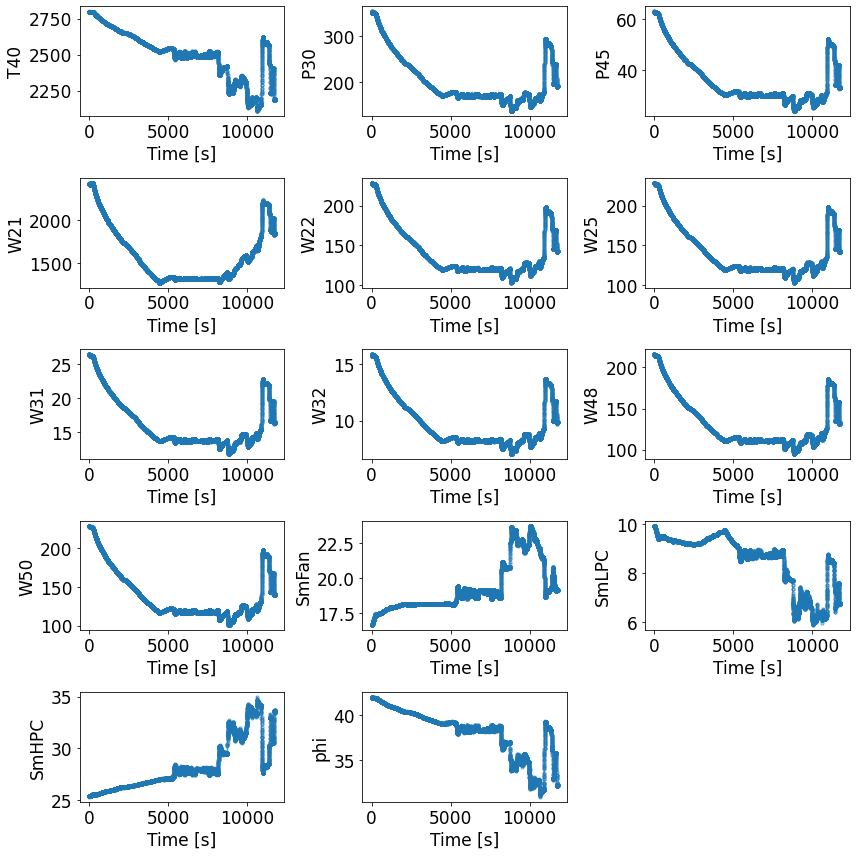

In [36]:
df_X_v_u_c = df_X_v.loc[(df_A.unit == 2) & (df_A.cycle == 1)]
df_X_v_u_c.reset_index(inplace=True, drop=True)
plot_df_single_color(df_X_v_u_c, X_v_var, X_v_var, name=graph_folder + 'eda_virtual_sensor_unit_2_cycle_1.jpeg')

## Combined dataset

Combine the types of variables into one single dataframe for further analysis. Use pandas_profiling to generate a profile report, check correlation by generating a heatmap.


In [14]:
# defining longer more meaningful names for the variables

# Auxiliary data
df_A = DataFrame(data=A, columns=['unit','flight_cycle_num','flight_class','health_state'])

# Scenario descriptors
df_W = DataFrame(data=W, columns=['altitude','mach_number','throttle_resolver_angle','fan_inlet_temp'])

# Measurements
physical_sensors = [
    'fuel_flow','physical_fan_speed','physical_core_speed','lpc_temp','hpc_temp','hpt_temp','lpt_temp',
    'bypass_duct_temp','fan_in_pressure','fan_out_pressure','lpc_pressure','hpc_static_pressure','burner_out_pressure','lpt_pressure'
    ]
df_X_s = DataFrame(data=X_s, columns=physical_sensors)

# Virtual sensors
virtual_sensors = [
    'total_temp_burner_outlet','total_pressure_hpc_outlet','total_pressure_hpt_outlet','fan_flow','lpc_outflow',
    'hpc_inflow','hpt_coolant_bleed','lpt_coolant_bleed','hpt_outflow','lpt_outflow','fan_stall_margin',
    'lpc_stall_margin','hpc_stall_margin','ratio_fuel_flow_to_static_hpc_pressure'
]
df_X_v = DataFrame(data=X_v, columns=virtual_sensors)

# Health parameters
df_T = DataFrame(data=T, columns=[
    'fan_efficiency_mod','fan_flow_mod','lpc_efficiency_mod','lpc_flow_mod','hpc_efficiency_mod','hpc_flow_mod',
    'hpt_efficiency_mod','hpt_flow_mod','lpt_efficiency_mod','lpt_flow_mod'
])

# RUL
df_Y = DataFrame(data=Y, columns=['RUL'])

In [15]:
df_all = pd.concat([df_A, df_W, df_T, df_X_s, df_X_v, df_Y], axis=1)
profile = ProfileReport(df_all, title='Pandas Profiling Report', minimal=True)

In [46]:
# Save the report to an html file - takes a while to run
profile.to_file(output_file='eda_report.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00,  7.29it/s]


Generate correlation matrices (takes time to run).

In [ ]:
def plot_corr(df, fig_name = None):
    corr_mat = df.corr()

    size = len(corr_mat.columns)
    f,ax = plt.subplots(figsize=(size, size))
    sns.heatmap(corr_mat.corr().abs(), annot=True, linewidths=.5, fmt= '.2f',ax=ax)
    ax3 = ax.twiny()
    ax3.set_aspect("equal")
    ax3.set_xlim([0,ax.get_xlim()[1]])
    ax3.set_xticks(ax.get_xticks())
    ax3.set_xticklabels(corr_mat.columns.tolist())
    ax3.tick_params(top=True)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.spines['bottom'].set_visible(False)
    ax3.spines['left'].set_visible(False)

    if fig_name is not None:
        plt.savefig(fig_name)

plot_corr(df_all, graph_folder + 'eda_corr_all.jpeg')

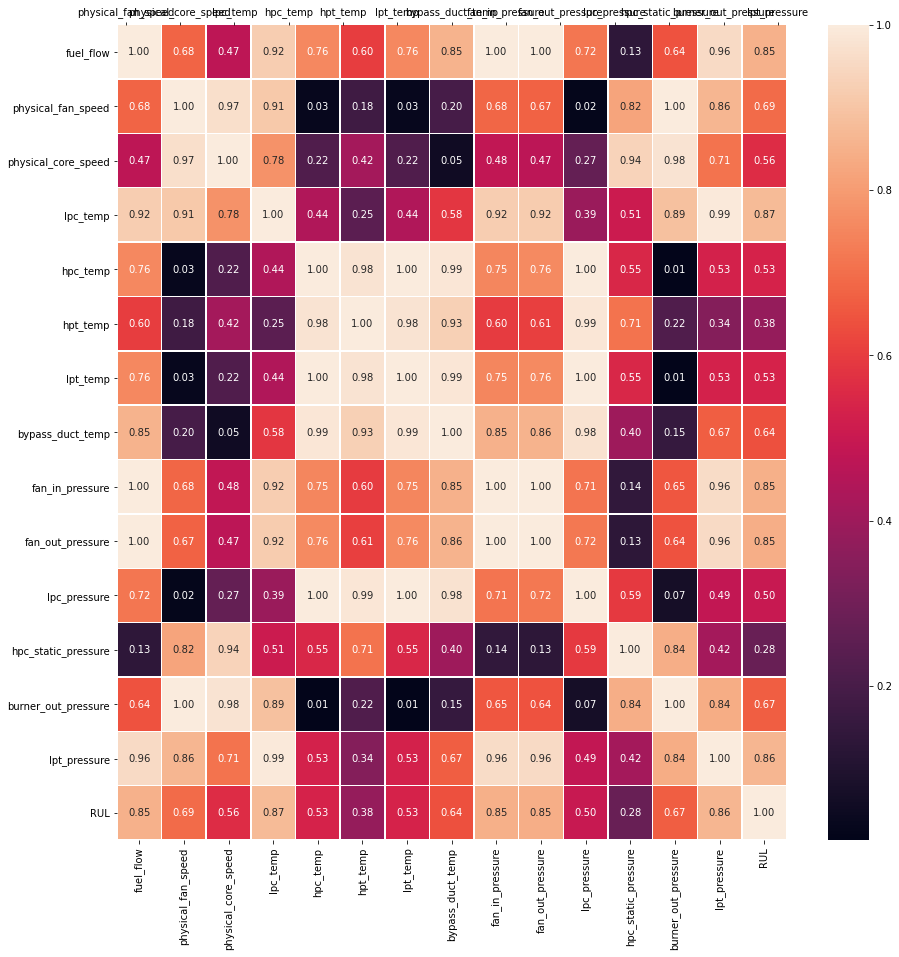

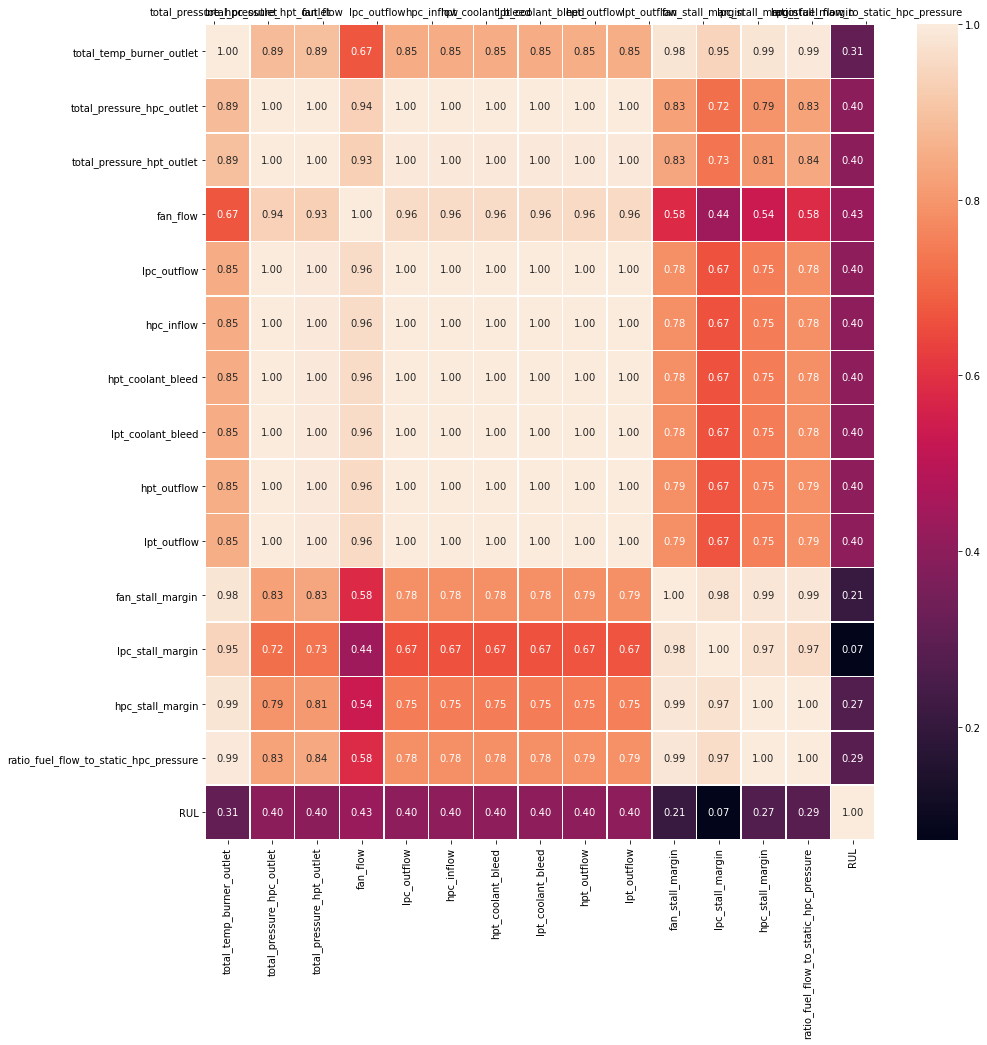

In [51]:
df_physical = pd.concat([df_X_s, df_Y], axis=1)
df_virtual = pd.concat([df_X_v, df_Y], axis=1)

# seperate correlation matrices
plot_corr(df_physical, graph_folder + 'eda_correlation_matrix_physical.jpeg')
plot_corr(df_virtual, graph_folder + 'eda_correlation_matrix_virtual.jpeg')

Plot the combined sensor readings against RUL.

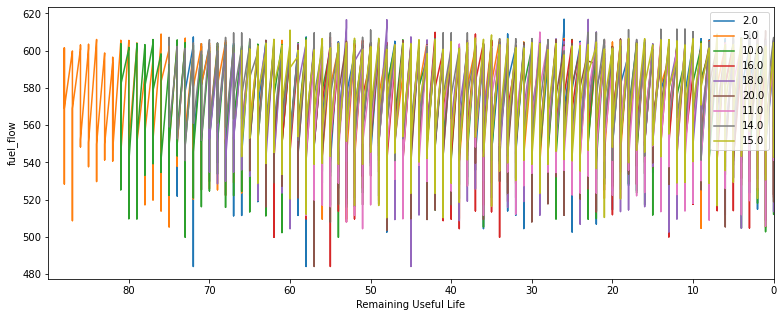

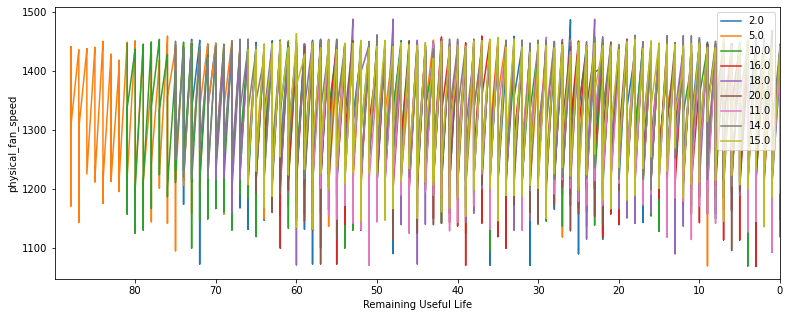

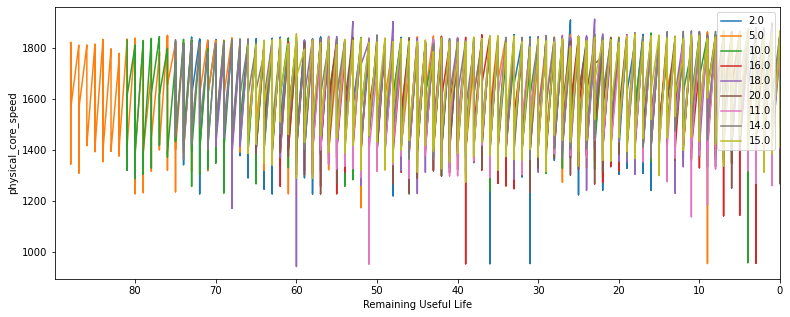

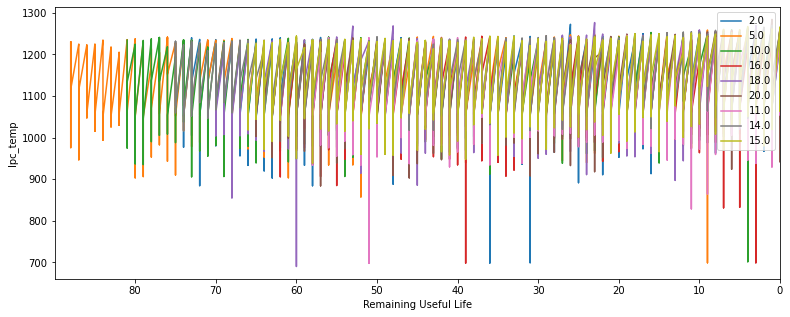

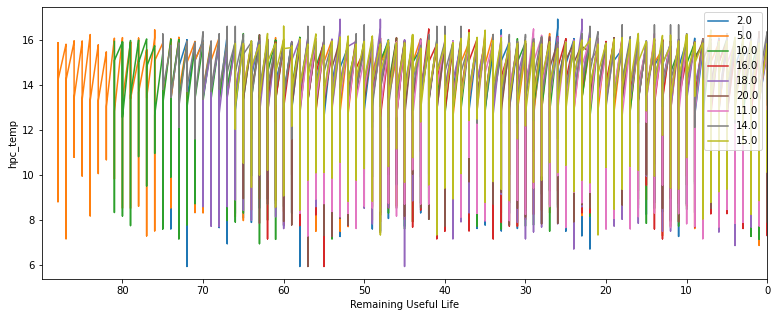

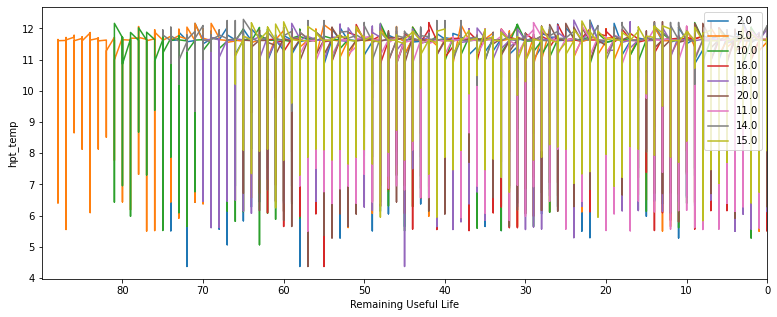

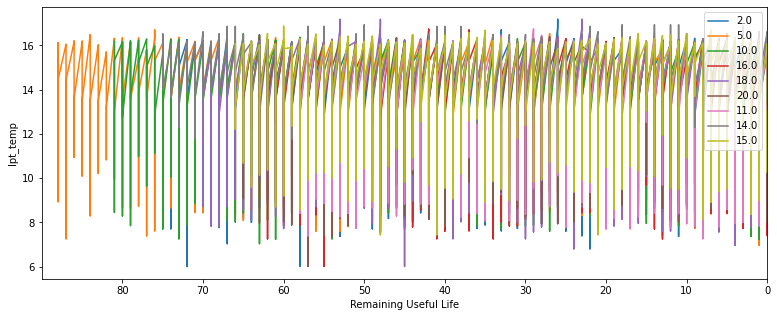

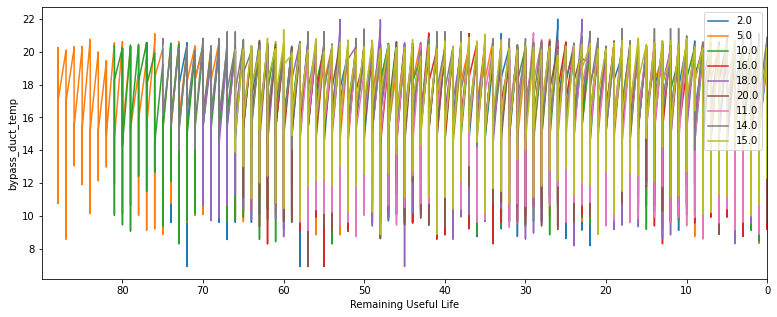

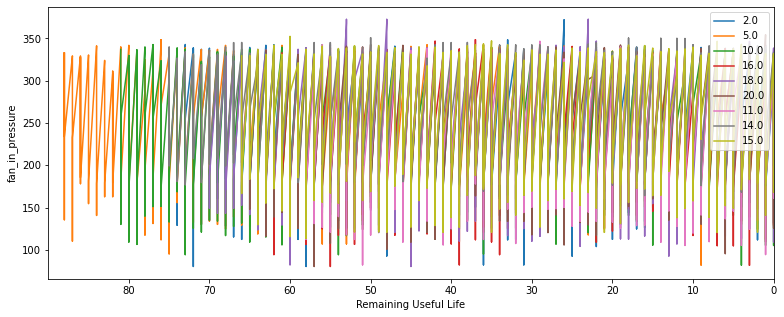

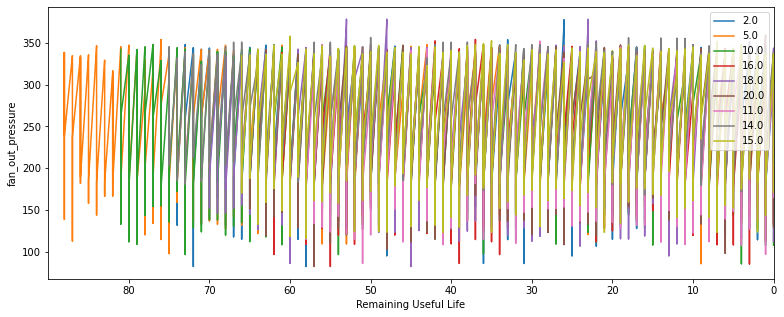

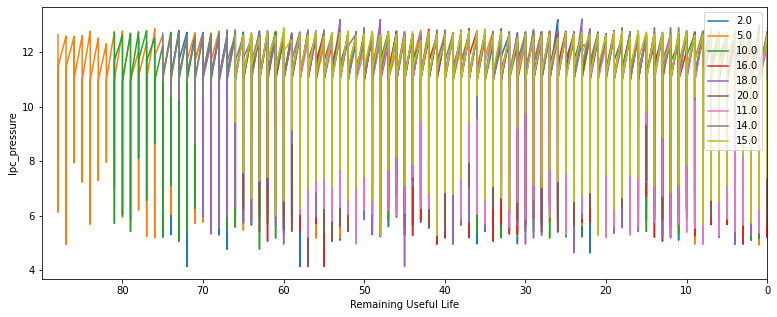

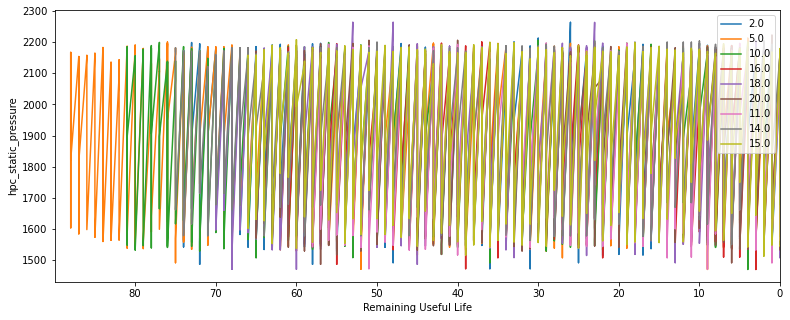

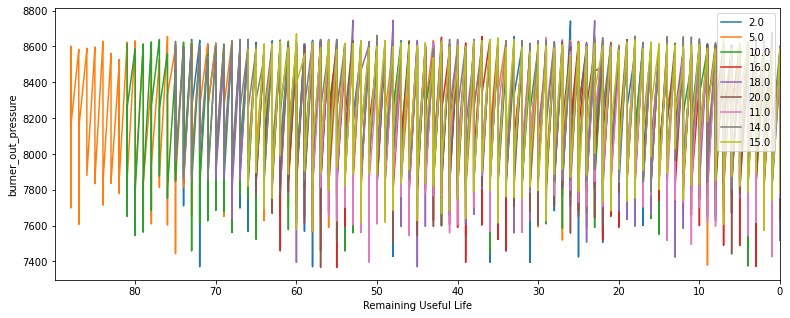

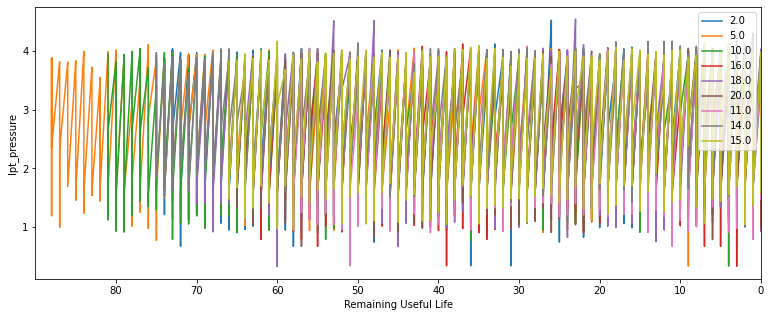

In [20]:
def plot_sensor(sensor_name):
    plt.figure(figsize=(13,5))
    for i in df_all['unit'].unique():
        plt.plot('RUL', sensor_name, 
                     data=df_all[df_all['unit']==i])
            
    plt.xlim(90, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 90, 10))
    plt.ylabel(sensor_name)
    plt.xlabel('Remaining Useful Life')
    plt.legend(df_all['unit'].unique(), loc='upper right')
    plt.savefig(graph_folder + 'sensors/eda_sensor_' + sensor_name + '.jpeg')
    plt.show()

for sensor_name in physical_sensors:
    plot_sensor(sensor_name)

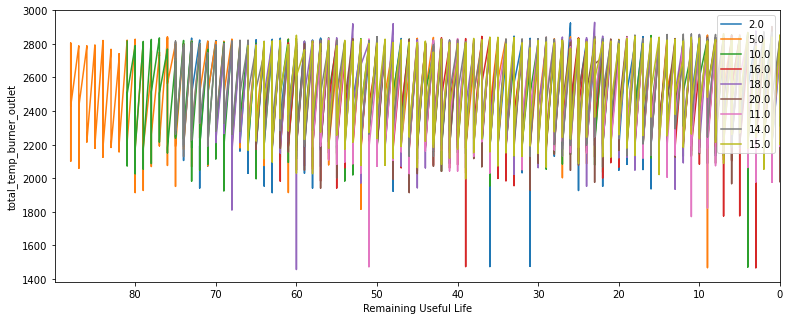

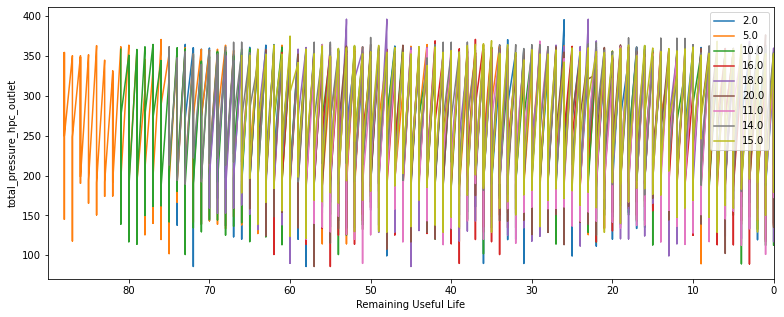

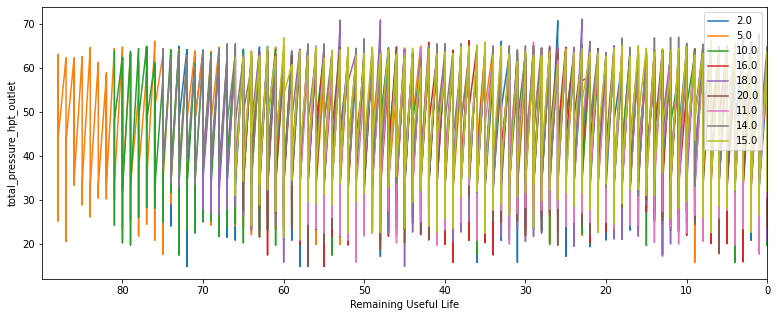

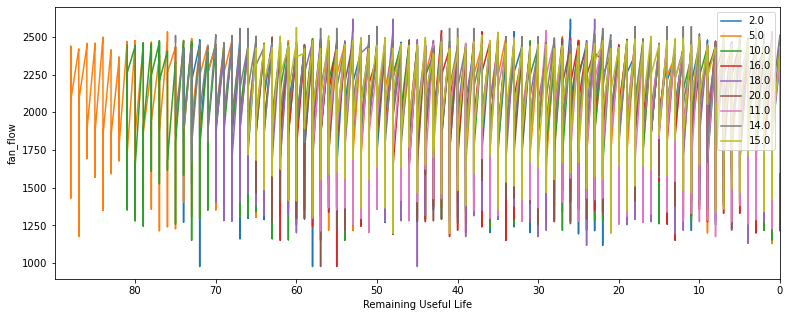

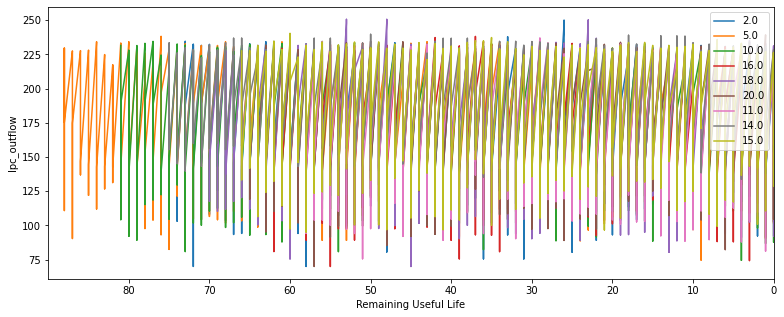

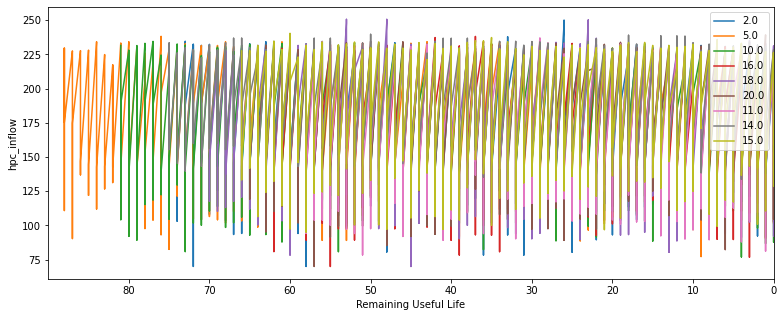

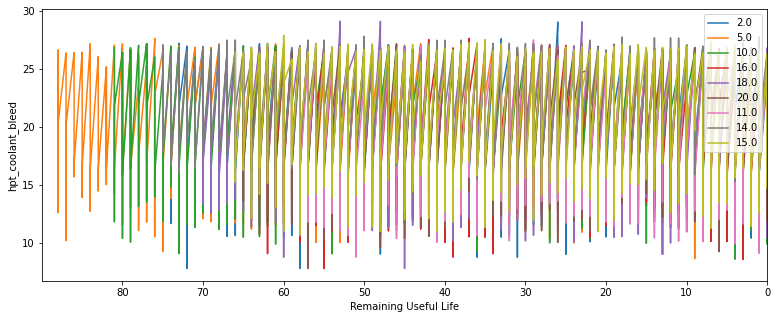

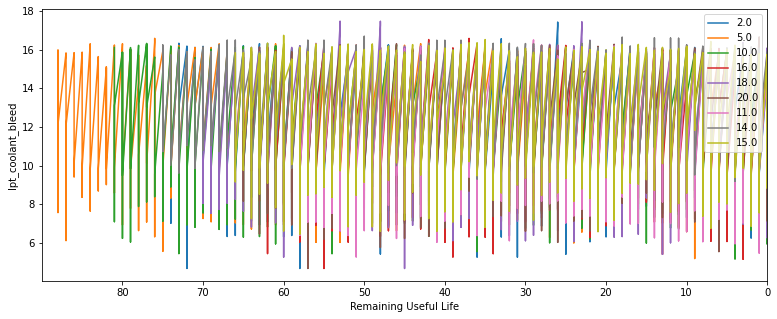

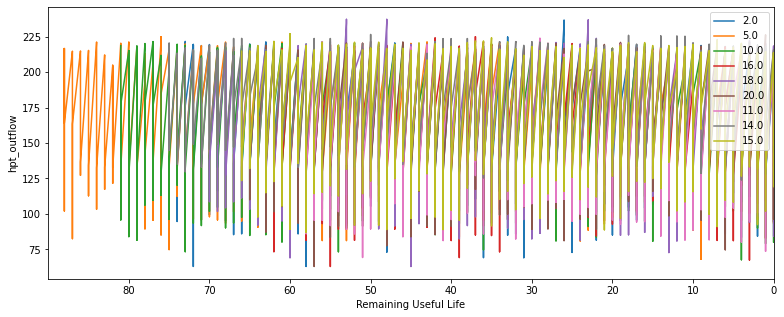

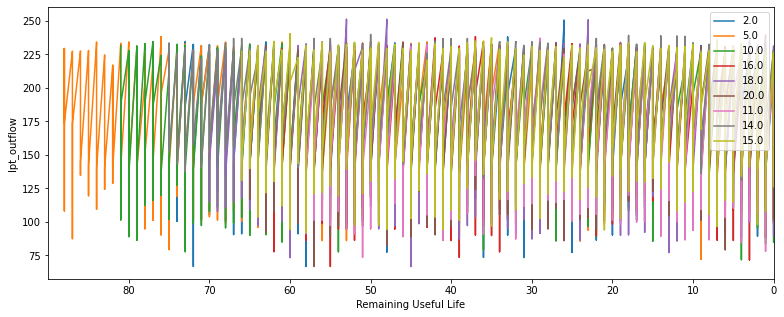

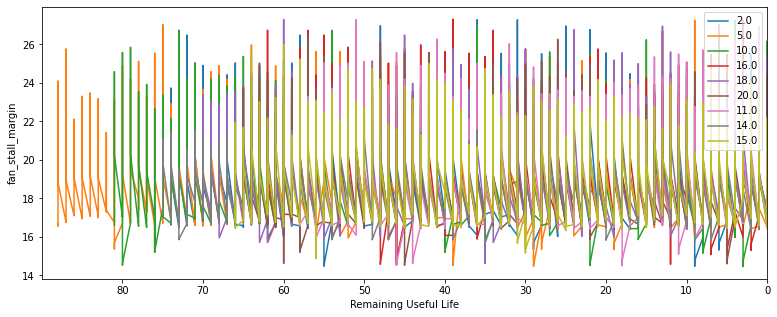

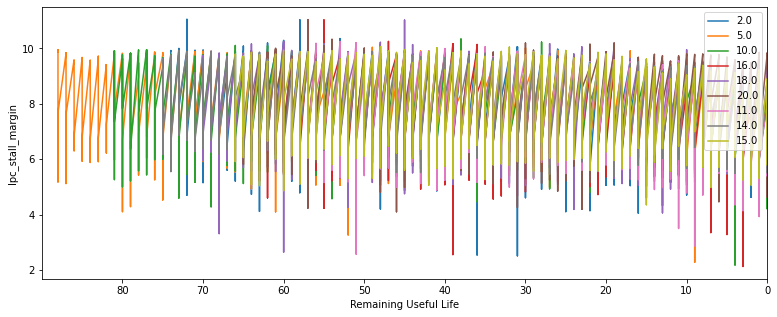

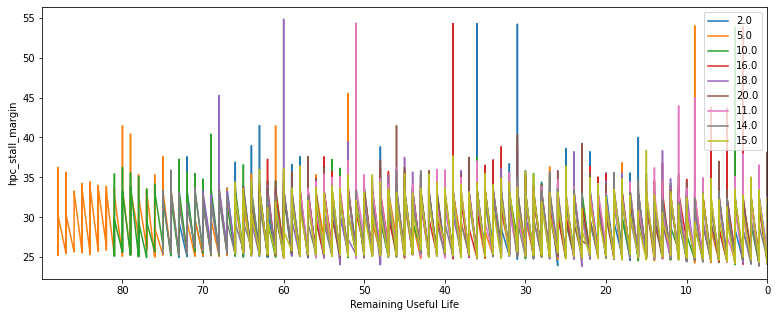

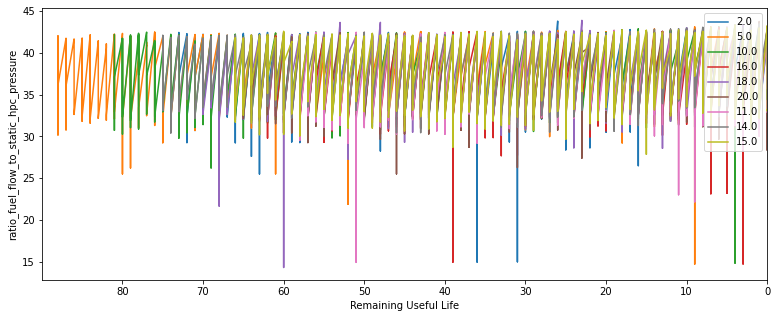

In [21]:
for sensor_name in virtual_sensors:
    plot_sensor(sensor_name)